In [1]:
import numpy as np
import matplotlib.pyplot as plt
import os
import sys
sys.path.append(os.path.abspath('../'))
from sampling_utils import thinning_T
from hawks import hawkes, plotHawkes, iterative_sampling

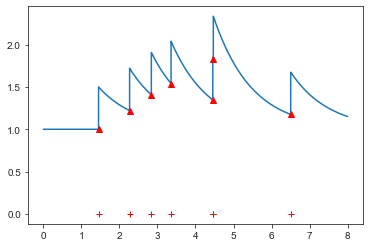

In [2]:

mu0 = 1
alpha = 0.5
w = 1
lambda_max = 5
T = 8
maxNev = 25
def constant(x): return mu0
initial_sample, indicators = thinning_T(0, constant, lambda_max, maxNev, T)
events = {initial_sample[i]: indicators[i] for i in range(len(initial_sample))}
all_events = {}
all_events[mu0] = events
iterative_sampling(all_events, events, mu0, alpha, w, lambda_max, maxNev, T)
sampled_events = list(all_events.keys())[1:]
sampled_events.sort()
sampled_events = np.array(sampled_events)
lambdas = hawkes(sampled_events, mu0, alpha, w)
plotHawkes(sampled_events, mu0, alpha, w, T, 10000.0, label= 'intensity')
plt.plot(sampled_events, lambdas, 'r^')
plt.show() 